In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import dill

In [2]:
# verify kernel won't crash due to MKL issue from future imports
import sklearn.linear_model.tests.test_randomized_l1

# Plotting from section 13 of `2.1.1 run same mixtures through Cibersort for comparison.ipynb`

In [3]:
[
    merged_samples, cleaner_gt, friendly_mixture_descriptions, example_result,
    cib_class_names, rollup_groundtruth, rollupsums_df, col_order, rollups
] = pickle.load(open('logs/tmp_2.1.1_plotting.pkl', 'rb'))

In [4]:
print('Cibersort Diagnostics for hyper (inserted in google doc):')
for key,row in example_result[['RMSE', 'P-value']].iterrows():
    print("mixture %d" % (key+1))
    print("{{{mix%d_rmse:%0.2f}}}" % (key+1, row['RMSE']))
    print("{{{mix%d_pval:%0.1f}}}" % (key+1, row['P-value']))
example_result[['RMSE', 'P-value']].iloc[[6,1,9]]

Cibersort Diagnostics for hyper (inserted in google doc):
mixture 1
{{{mix1_rmse:0.28}}}
{{{mix1_pval:0.0}}}
mixture 2
{{{mix2_rmse:0.34}}}
{{{mix2_pval:0.0}}}
mixture 3
{{{mix3_rmse:0.30}}}
{{{mix3_pval:0.0}}}
mixture 4
{{{mix4_rmse:0.33}}}
{{{mix4_pval:0.0}}}
mixture 5
{{{mix5_rmse:0.27}}}
{{{mix5_pval:0.0}}}
mixture 6
{{{mix6_rmse:0.34}}}
{{{mix6_pval:0.0}}}
mixture 7
{{{mix7_rmse:0.45}}}
{{{mix7_pval:0.0}}}
mixture 8
{{{mix8_rmse:0.44}}}
{{{mix8_pval:0.0}}}
mixture 9
{{{mix9_rmse:0.41}}}
{{{mix9_pval:0.0}}}
mixture 10
{{{mix10_rmse:0.49}}}
{{{mix10_pval:0.0}}}


,RMSE,P-value
6,0.452792,0.0
1,0.339896,0.0
9,0.486806,0.0


In [17]:
#sns.set_context('paper')
sns.set_style("darkgrid")

In [8]:
def savefig(fig, *args, **kwargs):
    """
    Wrap figure.savefig defaulting to tight bounding box.
    From https://github.com/mwaskom/seaborn/blob/dfdd1126626f7ed0fe3737528edecb71346e9eb0/seaborn/axisgrid.py#L1840
    """
    kwargs.setdefault("bbox_inches", "tight")
    fig.savefig(*args, **kwargs)

In [9]:
def extract_values_for_mixture_by_id(key):
    """
    key: 1-indexed, meaning mixture 1 to mixture 10
    
    based on:
    for (key, grp), \
            (_, groundtruth_base), \
            friendly_title, \
            (_, cib_vals_base), \
            (mixID_rolledup, groundtruth_rolledup), \
            (_, cib_vals_rolledup) in zip(merged_samples.groupby('sample_id'),
                                          cleaner_gt.iterrows(),
                                          #friendly_mixture_descriptions2,
                                          friendly_mixture_descriptions,
                                          example_result[cib_class_names].iterrows(),
                                          rollup_groundtruth.groupby('mixID'),
                                          rollupsums_df.iterrows()
    """
    grp = merged_samples[merged_samples['sample_id'] == key]
    groundtruth_base = cleaner_gt.iloc[key-1]
    cib_vals_base = example_result[cib_class_names].iloc[key-1]
    groundtruth_rolledup = rollup_groundtruth[rollup_groundtruth['mixID'] == key-1]
    cib_vals_rolledup = rollupsums_df.iloc[key-1]
    
    return (key, grp, groundtruth_base, cib_vals_base, groundtruth_rolledup, cib_vals_rolledup)

In [10]:
def plot_single_mixture_results(mixture_info, friendly_title):
    #flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"] # http://seaborn.pydata.org/tutorial/color_palettes.html
    #sns.palplot(flatui)
    paired_colors = sns.color_palette("Paired_r", 12)
    #sns.palplot(paired_colors)
    
    (key, grp, groundtruth_base, cib_vals_base, groundtruth_rolledup, cib_vals_rolledup) = mixture_info

    with sns.plotting_context('paper'):
        f, ax = plt.subplots( figsize=(12,8))
        g = sns.boxplot(data = grp,
                       y='subset_name',
                       x='estimate',
                       ax=ax,
                       hue='type',
                       order=col_order,
                        # some additional parameters that we think may help:
                        saturation=1,
                        linewidth=1, # not sure about this one
                        dodge=False, # avoid hue nesting
                       #palette=[flatui[0], flatui[1]]
                        palette=paired_colors[0:2]
                       )
        g.set_title(friendly_title) 

        # ground truth
        gt1 = pd.DataFrame(groundtruth_base).reset_index()
        gt1.columns = ['rollup', 'estimate']
        gt1['type'] = 'subset'
        gt2 = groundtruth_rolledup[['rollup', 'estimate']].copy()
        gt2['type'] = 'rollup'
        gt = pd.concat([gt1, gt2])

        sns.stripplot(
            x="estimate",
            y="rollup",
            data=gt,
            hue='type',
            order=col_order,
            linewidth=0,
            size=15,
            alpha=.9,
            marker=(5, 1),
            #palette=[flatui[5], flatui[3]],
            palette=paired_colors[2:4],
            zorder=5,
            jitter=False,
            label='Ground Truth' # https://github.com/mwaskom/seaborn/issues/940 -- without this line, the stars aren't shown in legend entries made by "hue" param; instead you get a ton of dupe Ground Truth star labels
        )

        # add cibersort points
        cb_base = pd.DataFrame(cib_vals_base).reset_index()
        cb_base.columns = ['SubSet', 'estimate']
        cb_base['type'] = 'subset'

        cb_rolledup = pd.DataFrame(cib_vals_rolledup).reset_index()
        cb_rolledup.columns = ['SubSet', 'estimate']
        cb_rolledup['type'] = 'rollup'

        cb = pd.concat([cb_base, cb_rolledup])
        cb.SubSet = cb.SubSet.str.replace('_', ' ') # normalize names

        sns.stripplot(
            x="estimate",
            y="SubSet",
            data=cb,
            hue='type',
            order=col_order,
            linewidth=0,
            size=15,
            alpha=.9,
            marker=(3, 0),
            #palette=[flatui[2], flatui[4]],
            palette=paired_colors[4:6],
            zorder=6,
            jitter=False,
            label='Cibersort' # see above again re this label parameter
        )

        g.set_xlabel('Mixture proportion')
        g.set_ylabel('Cell type')
        g.set_xbound(0, 1)

        # show legend, and subselect because stripplot adds one legend item per point it appears
        handles, labels = ax.get_legend_handles_labels()
        """
        want legend items:
        * infino samples: items 0, 1
        * ground truth stars: items 2, 3
        * cibersort triangles: items 2+len(col_order)+2, 2+len(col_order)+2+1
        """
        chosen_idx = [1,0, 2,3, 2+len(col_order)+2, 2+len(col_order)+2+1]
        chosen_handles = [handles[i] for i in chosen_idx]
        #chosen_labels = [labels[i] for i in chosen_idx]
        chosen_labels = ['Infino (sums)', 'Infino', 'Ground Truth (sums)', 'Ground Truth', 'Cibersort (sums)', 'Cibersort']
        legend = ax.legend(
            chosen_handles,
            chosen_labels,
            loc='lower right',
            frameon=True)
        frame = legend.get_frame()
        frame.set_edgecolor('red')
        frame.set_facecolor('white')

        # shade background
        #fill1 = plt.axhspan('B', 'CD4 T', facecolor='0.5', alpha=0.5)
        fill1 = plt.axhspan(-0.5, 3.5, facecolor='0.8', alpha=0.3)
        fill3 = plt.axhspan(11.5, 15.5, facecolor='0.8', alpha=0.3)

        # improve label format
        # https://stackoverflow.com/a/34426167/130164
        for label in ax.get_yticklabels():
            if label.get_text() in rollups.keys():
                label.set_size(15)
                label.set_backgroundcolor("yellow")
                label.set_weight("bold")
                label.set_color("red")
            else:
                label.set_fontstyle("italic")
                label.set_weight("bold")


        return f,ax
        

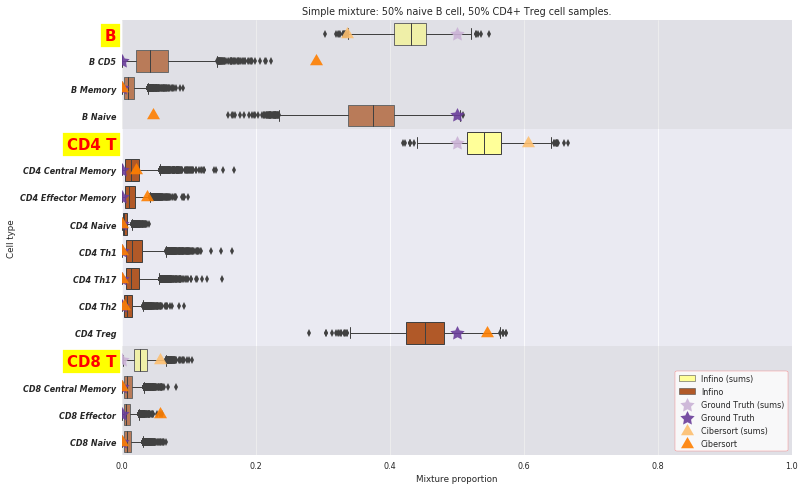

In [11]:
f,ax = plot_single_mixture_results(extract_values_for_mixture_by_id(7),
                                   'Simple mixture: 50% naive B cell, 50% CD4+ Treg cell samples.')

# Quantification of results

TODO(Eliza)

See https://github.com/jburos/simtest_jm/blob/master/docker_image/recover_params.function.R and https://github.com/jburos/simtest_jm/blob/master/simulation_results_etaslope.md.

> the first is a script that computes the pctile of the true value in the posterior distribution. the second shows an example plot of what this looks like over a few simulated runs. 

# New plots

these are some examples of the posterior-interval summary plots in R: http://mc-stan.org/bayesplot/articles/plotting-mcmc-draws.html#posterior-uncertainty-intervals

seaborn example: https://seaborn.pydata.org/examples/kde_joyplot.html

> may want to center on true value. just center x axis at 0 == truth. to check single parameter across multiple runs.
> (if you’re summarising  a single run (across cell types), then no need to center)

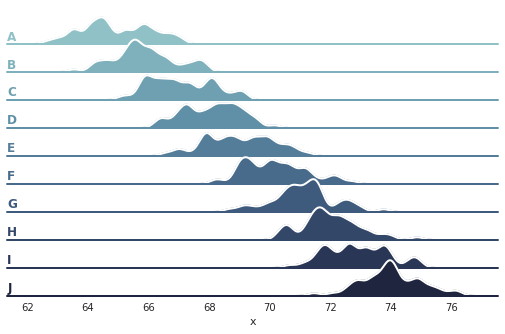

In [34]:
# based on https://seaborn.pydata.org/examples/kde_joyplot.html

# this line's rc settings make a huge difference
# sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# axes.facecolor is "color of the area where the data are drawn"
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    # Create the data
    rs = np.random.RandomState(1979)
    x = rs.randn(500)
    g = np.tile(list("ABCDEFGHIJ"), 50)
    df = pd.DataFrame(dict(x=x, g=g))
    m = df.g.map(ord)
    df["x"] += m

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5, palette=pal)

    ## Draw the densities in a few steps
    # this is the shaded area
    g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    # this is the outline line of the top of the distribution
    g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2) 
    # this is the dividing horizontal line
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color, 
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "x")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)
    
    # Instead, disabling overlap.
    # Some `subplots_adjust` line is necessary. without this, nothing appears
    #g.fig.subplots_adjust(hspace=0)

    # Remove axes details that don't play will with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

TypeError: __init__() got an unexpected keyword argument 'ax'

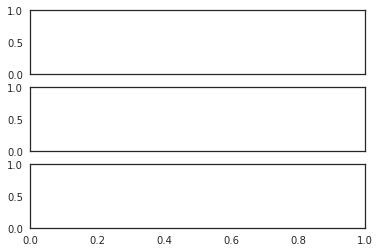

In [35]:
# now try this with three stacked plots (we want to break into CD4 plot, CD8 plot, B cell plot)

with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    f, axarr = plt.subplots(3, sharex=True)
    
    # Create the data
    rs = np.random.RandomState(1979)
    x = rs.randn(500)
    g = np.tile(list("ABCDEFGHIJ"), 50)
    df = pd.DataFrame(dict(x=x, g=g))
    m = df.g.map(ord)
    df["x"] += m

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    
    for ax in axarr:
        g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5, palette=pal, ax=ax)

        ## Draw the densities in a few steps
        # this is the shaded area
        g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
        # this is the outline line of the top of the distribution
        g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2) 
        # this is the dividing horizontal line
        g.map(plt.axhline, y=0, lw=2, clip_on=False)

        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color, 
                    ha="left", va="center", transform=ax.transAxes)

        g.map(label, "x")

        # Set the subplots to overlap
        g.fig.subplots_adjust(hspace=-.25)

        # Instead, disabling overlap.
        # Some `subplots_adjust` line is necessary. without this, nothing appears
        #g.fig.subplots_adjust(hspace=0)

        # Remove axes details that don't play will with overlap
        g.set_titles("")
        g.set(yticks=[])
        g.despine(bottom=True, left=True)



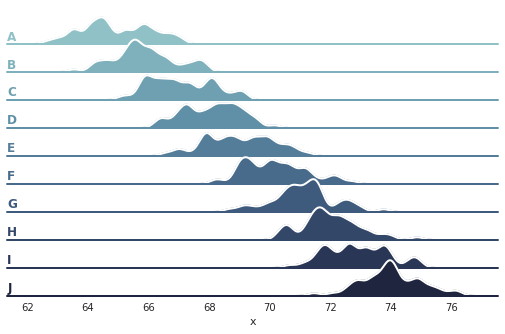

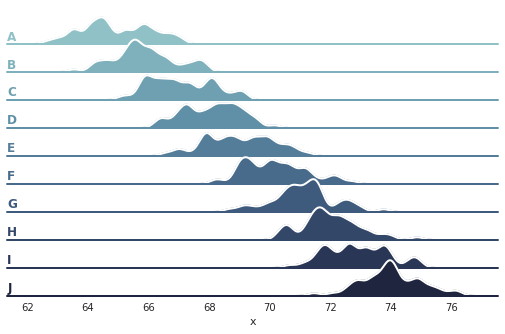

In [55]:
def gen_plot():
    with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
        g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5, palette=pal)

        ## Draw the densities in a few steps
        # this is the shaded area
        g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
        # this is the outline line of the top of the distribution
        g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2) 
        # this is the dividing horizontal line
        g.map(plt.axhline, y=0, lw=2, clip_on=False)

        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color, 
                    ha="left", va="center", transform=ax.transAxes)

        g.map(label, "x")

        # Set the subplots to overlap
        g.fig.subplots_adjust(hspace=-.25)

        # Instead, disabling overlap.
        # Some `subplots_adjust` line is necessary. without this, nothing appears
        #g.fig.subplots_adjust(hspace=0)

        # Remove axes details that don't play will with overlap
        g.set_titles("")
        g.set(yticks=[])
        g.despine(bottom=True, left=True)
        return g
g1 = gen_plot()
g2 = gen_plot()

[Figures can't be merged](https://stackoverflow.com/a/44159496/130164). Oops.

But: FacetGrid allows for multi-dimensional levels. There's `hue`, `row`, and `col`. We're not using `col` above, so let's add two `col` levels and plot the facetgrids side by side:

In [37]:
df.head()

,g,x
0,A,64.038123
1,B,66.147050
2,C,66.370011
3,D,68.791019
4,E,70.583534


In [43]:
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()
df1['copynum'] = 1
df2['copynum'] = 2
df3['copynum'] = 3
merged_df = pd.concat([df1, df2, df3])
merged_df.head()

,g,x,copynum
0,A,64.038123,1
1,B,66.147050,1
2,C,66.370011,1
3,D,68.791019,1
4,E,70.583534,1


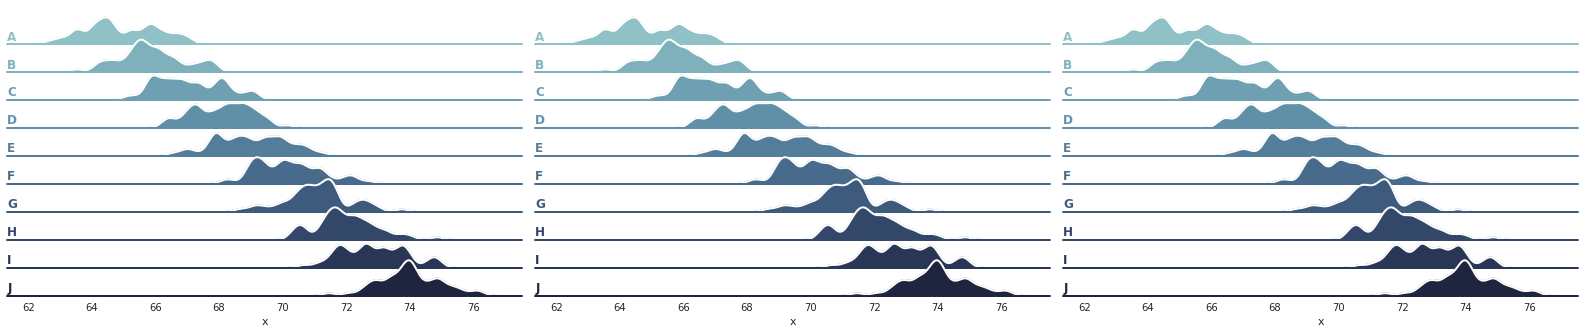

In [56]:
def gen_plot():
    with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
        g = sns.FacetGrid(merged_df, row="g", hue="g", aspect=15, size=.5, palette=pal,
                         col='copynum')

        ## Draw the densities in a few steps
        # this is the shaded area
        g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
        # this is the outline line of the top of the distribution
        g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2) 
        # this is the dividing horizontal line
        g.map(plt.axhline, y=0, lw=2, clip_on=False)

        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color, 
                    ha="left", va="center", transform=ax.transAxes)

        g.map(label, "x")

        # Set the subplots to overlap
        g.fig.subplots_adjust(hspace=-.25)

        # Instead, disabling overlap.
        # Some `subplots_adjust` line is necessary. without this, nothing appears
        #g.fig.subplots_adjust(hspace=0)

        # Remove axes details that don't play will with overlap
        g.set_titles("")
        g.set(yticks=[])
        g.despine(bottom=True, left=True)
        return g
gen_plot()

So this works to give us our B cell, T-CD4, and T-CD8 plots.

But FacetGrid might not be flexible enough to allow us to also plot rollups in a different color. That might require setting `hue` to a new column that we define manually, and specifying a palette manually (as we did before). Or might have to break out of this and just make the subplots ourselves...

In [47]:
# hue will be set to J for J rows and A for all other rows
df['hue'] = df['g'].apply(lambda h: 'J' if h == 'J' else 'A')
df.hue.value_counts()

A    450
J     50
Name: hue, dtype: int64

In [48]:
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()
df1['copynum'] = 1
df2['copynum'] = 2
df3['copynum'] = 3
merged_df = pd.concat([df1, df2, df3])
merged_df.head()

,g,x,hue,copynum
0,A,64.038123,A,1
1,B,66.147050,A,1
2,C,66.370011,A,1
3,D,68.791019,A,1
4,E,70.583534,A,1


In [50]:
merged_df.hue.value_counts()

A    1350
J     150
Name: hue, dtype: int64

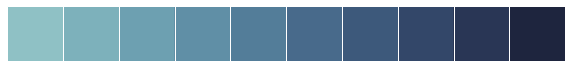

In [51]:
sns.palplot(pal)

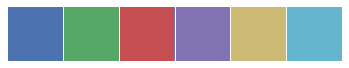

In [52]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

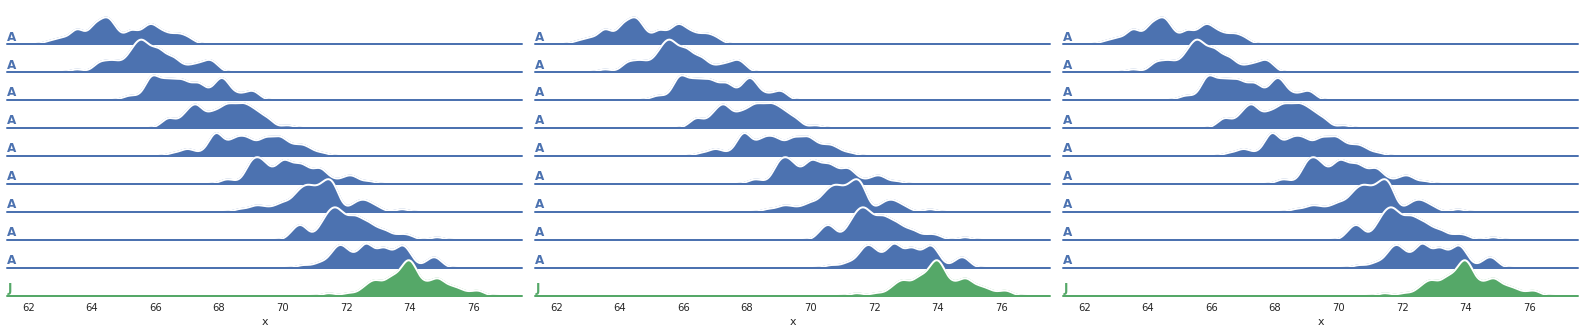

In [57]:
def gen_plot2():
    with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
        g = sns.FacetGrid(merged_df, row="g", hue="hue", aspect=15, size=.5,
                          #palette=pal,
                          palette=current_palette,
                         col='copynum')

        ## Draw the densities in a few steps
        # this is the shaded area
        g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
        # this is the outline line of the top of the distribution
        g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2) 
        # this is the dividing horizontal line
        g.map(plt.axhline, y=0, lw=2, clip_on=False)

        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color, 
                    ha="left", va="center", transform=ax.transAxes)

        g.map(label, "x")

        # Set the subplots to overlap
        g.fig.subplots_adjust(hspace=-.25)

        # Instead, disabling overlap.
        # Some `subplots_adjust` line is necessary. without this, nothing appears
        #g.fig.subplots_adjust(hspace=0)

        # Remove axes details that don't play will with overlap
        g.set_titles("")
        g.set(yticks=[])
        g.despine(bottom=True, left=True)
        return g
gen_plot2()

It'd be nice to have a slowly-changing palette like `pal` for the subsets, then tack on a bold color like green from `current_palette` for the rollup.

A problem with the above is that the row labels are coming from `hue` not `row`.

In [65]:
merged_df.head()

,g,x,hue,copynum
0,A,64.038123,A,1
1,B,66.147050,A,1
2,C,66.370011,A,1
3,D,68.791019,A,1
4,E,70.583534,A,1


(0      64.038123
10     65.723433
20     67.067787
30     65.215980
40     66.707504
50     65.631442
60     66.684976
70     63.015903
80     64.106152
90     64.443467
100    65.181087
110    64.466540
120    63.080895
130    64.119624
140    64.484735
150    64.007184
160    65.196320
170    63.649979
180    66.444729
190    65.938141
200    64.507826
210    67.004673
220    64.630121
230    63.480782
240    63.670576
250    66.018931
260    66.203872
270    65.960129
280    64.713854
290    64.199111
300    64.839984
310    66.754530
320    62.671687
330    64.086624
340    66.226185
350    65.858129
360    63.413301
370    65.282763
380    64.430808
390    65.601947
400    65.784255
410    66.339326
420    63.522999
430    64.559755
440    65.844975
450    64.243303
460    65.340230
470    64.413991
480    63.521875
490    64.724145
Name: x, dtype: float64, 0      A
10     A
20     A
30     A
40     A
50     A
60     A
70     A
80     A
90     A
100    A
110    A
120    A
130    

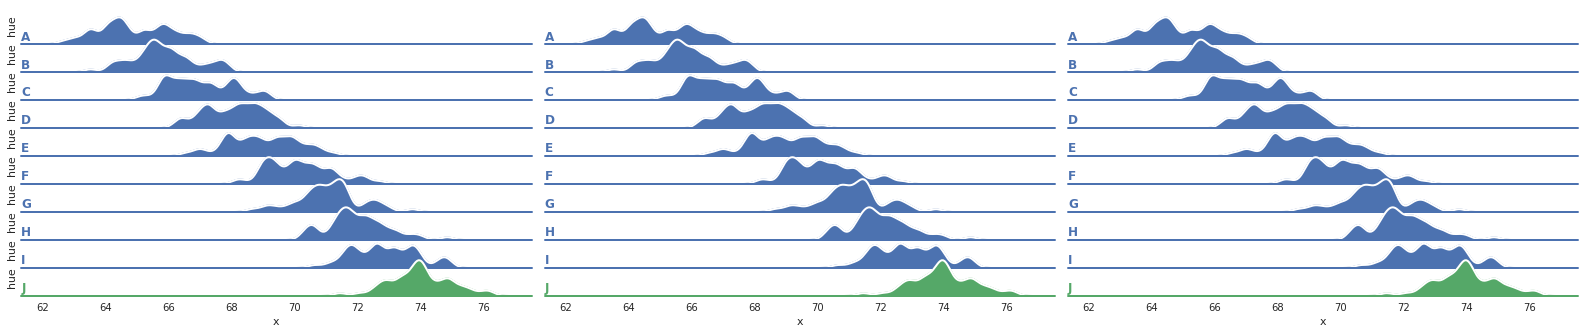

In [73]:
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    g = sns.FacetGrid(merged_df, row="g", hue="hue", aspect=15, size=.5,
                      #palette=pal,
                      palette=current_palette,
                     col='copynum')

    ## Draw the densities in a few steps
    # this is the shaded area
    g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    # this is the outline line of the top of the distribution
    g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2) 
    # this is the dividing horizontal line
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    #def label(x, color, label, g):
        #print(g)
    #def label(x, color, label):
    def label(*args, **kwargs):
        #x = kwargs['data']
        print(args)
        print(kwargs)
        #color = args[1]
        #label = args[2]
        color = kwargs['color']
        label = args[-1].iloc[0]
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color, 
                ha="left", va="center", transform=ax.transAxes)

    #g.map(label, "x", color='hue', label='g')
    g.map(label, "x", 'hue', 'g')

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Instead, disabling overlap.
    # Some `subplots_adjust` line is necessary. without this, nothing appears
    #g.fig.subplots_adjust(hspace=0)

    # Remove axes details that don't play will with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

```
For even more customization, you can work directly with the underling matplotlib Figure and Axes objects, which are stored as member attributes at fig and axes (a two-dimensional array), respectively. When making a figure without row or column faceting, you can also use the ax attribute to directly access the single axes.

g = sns.FacetGrid(tips, col="smoker", margin_titles=True, size=4)
g.map(plt.scatter, "total_bill", "tip", color="#338844", edgecolor="white", s=50, lw=1)
for ax in g.axes.flat:
    ax.plot((0, 50), (0, .2 * 50), c=".2", ls="--")
g.set(xlim=(0, 60), ylim=(0, 14));
```